In [1]:
import pandas as pd
import numpy as np
import datatable as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')

# 0. Loading Data

In [2]:
t = time.time()
datatable_df = dt.fread("microbiome_542.csv")
print("Load data into datatable df takes: " , time.time()-t , "secs")
t = time.time()
data = datatable_df.to_pandas()
print("Convert to pandas takes: " , time.time()-t, "secs")

Load data into datatable df takes:  59.492960929870605 secs
Convert to pandas takes:  21.755789041519165 secs


In [3]:
# some cleanup
# drop index column

data = data.drop(data.columns[0], axis=1)
data_copy = data.copy()

print('Data contains', data.shape[0], 'rows and ', data.shape[1], 'columns')

Data contains 9511 rows and  32961 columns


In [4]:
# data = data_copy.copy()

In [5]:
data.head()

,age_cat,bmi,bmi_cat,weight_kg,race,sex,alcohol_frequency,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae|s__Lachnospiraceae-unspecified,k__Bacteria|p__Cyanobacteria|c__4C0d-2|o__YS2|f__YS2|g__YS2|s__YS2-unspecified,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales|g__Bacteroidales|s__Bacteroidales-unspecified,...,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Catabacteriaceae|g__Catabacteriaceae|s__Catabacteriaceae-unspecified.66,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae|s__Ruminococcaceae-unspecified.4775,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales|g__Clostridiales|s__Clostridiales-unspecified.2357,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales|g__Bacteroidales|s__Bacteroidales-unspecified.257,k__Bacteria|p__Firmicutes|c__Erysipelotrichi|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Bulleidia|s__p-1630-c5.6,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrionaceae|s__Vibrionaceae-unspecified.2,k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Sphingobacteriaceae|s__Sphingobacteriaceae-unspecified.16,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Veillonellaceae|g__Phascolarctobacterium|s__Phascolarctobacterium-unspecified.120,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides-unspecified.712,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales|g__Bacteroidales|s__Bacteroidales-unspecified.258
0,60s,21.92,Normal,52,Caucasian,female,Daily,0.0,0.0,0.168299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50s,35.92,Obese,110.0,Caucasian,male,Rarely (a few times/month),0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50s,19.84,Normal,56.0,Not provided,female,Regularly (3-5 times/week),0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40s,34.89,Obese,86.0,Caucasian,female,Rarely (a few times/month),0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60s,30.02,Obese,74.0,Caucasian,female,Never,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Alpha Diversity

In [6]:
# add alpha diversity or so-called OTUs richness in the context of OTU studies
# alpha diversity is defined to be the number of observed non-zero microbiomes in a sample
alpha_diversity = (data.iloc[:, 7:] > 0).sum(axis=1)

# standardize
# alpha_diversity = (alpha_diversity - alpha_diversity.mean()) / alpha_diversity.std()                                

# F/B Ratio

In [7]:
# add F/B ratio - defined as p__Firmicutes / p__Bacteroidetes

def get_fb_ratio(data):
    p__Firmicutes = data.iloc[:,data.columns.str.contains('p__Firmicutes')].sum(axis=1)
    p__Bacteroidetes = data.iloc[:,data.columns.str.contains('p__Bacteroidetes')].sum(axis=1) 
    fb_ratio = p__Firmicutes / (p__Bacteroidetes + 1e-5)
    return fb_ratio

fb_ratio = get_fb_ratio(data_copy)

# Greedily merge variables together

# 1. Dealing with Sparsity

In [8]:
# todo: explain why sparsity is bad

## 1.1 Merge "too-sparse" variables

In [9]:
# transformation on microbiome variables
# to numpy for ease in operation
data_microbiome = data.iloc[:,7:].values

In [10]:
# an easy check of outliers
# see whether any of these samples has micriobiome variables sum up to value other than 1
# from scipy import stats
# print(stats.describe(data_microbiome.sum(axis=1)))

In [11]:
# print(stats.describe(data_microbiome.flatten()))

In [12]:
# no microbiome variable is full of zeros
print(((data_microbiome == 0).sum(axis=0) == 9511).sum(), 'microbiome variables contain values of only zeros')
print(((data_microbiome == 0).sum(axis=0) == 9510).sum(), 'microbiome variables contain only 1 value other than zero')
print(((data_microbiome == 0).sum(axis=0) == 9509).sum(), 'microbiome variables contain only 2 values other than zero')
print(((data_microbiome == 0).sum(axis=0) == 9508).sum(), 'microbiome variables contain only 3 values other than zero')

0 microbiome variables contain values of only zeros
7528 microbiome variables contain only 1 value other than zero
3503 microbiome variables contain only 2 values other than zero
2718 microbiome variables contain only 3 values other than zero


In [13]:
# average values of non-zeros micriobiome variables 
# this is calculated accross the data
m = data_microbiome[data_microbiome != 0].mean()

Average number of non-zeros per variable: 55.516


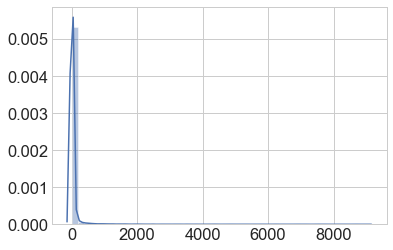

In [14]:
# average number of non-zeros entries per variable
nonzeros = (9511 - ((data_microbiome == 0).sum(axis=0)))
print('Average number of non-zeros per variable:' , round(nonzeros.mean(), 3))
# print(stats.describe(nonzeros))

# todo: prettify
sns.distplot(nonzeros)

**Discoveries**

- None of the variables contains only zeros 
- Sparsity was introduced to the dataset due to lots of zeors in most of the variables  

An intuitive strategy to reduce sparsity while maintaining the compositional property of the data is to merge sparse variables by adding them together. **Temporarily**, variables that 
1. contains less than 100 non-zeros values (about 1% of samples)  
2. has maximum value less than average of non-zeros entries accross the data
  
were merged together.  

IMO, the variables should be merged together before applying any zero value imputation because:  
1. it does not distort row sums too much even if the zeros were naively inputed by a small non-zero value, hereby preserve the compositional property  
2. if only a few samples have non-zeros values in the merged variables, they are potential outliers

In [15]:
# the strategy above
cols_ind = (((data_microbiome == 0).sum(axis=0) >= (9511 - 100)) & (data_microbiome.max(axis=0) <= m))
print(cols_ind.sum(), 'variables will be merged together.')

26376 variables will be merged together.


In [16]:
# a more greedy way of merging variables, using mean values as threshold
# (((data_microbiome == 0).sum(axis=0) >= (9511 - 100)) & (np.true_divide(data_microbiome.sum(axis=0),(data_microbiome !=0 ).sum(axis=0)) <= m)).sum()

In [17]:
# merge
merged_var = data_microbiome[:,cols_ind].sum(axis=1)

# drop from original data
data = data.drop(data.columns[7:][cols_ind], axis=1)

# append merged variable
data['Others'] = merged_var

In [18]:
print(data.shape[1], 'variables left')

6586 variables left


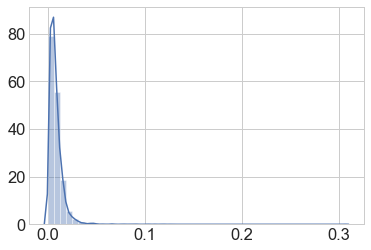

In [19]:
# todo: prettify
sns.distplot(merged_var)

In [20]:
# todo: decide what to do with potential outliers
(merged_var > 0.1).sum()

7

In [21]:
# free memory
del data_microbiome

## 1.2 Further Merge Variables by Microbiome Category

Though most of the variables were grouped, 6586 dimensional space is most likely to introduce problem in common statistical learning approach, more dimension reduction strategies were taken into consideration.  

**todo: correct pathetic wordings here with appropriate terminology**  

(taken from manun)
Bacteria name are categorized as Phylum (p) | Class (c) | Order (o) | Family (f) | Genus (g) | Species (s)

Column names of microbiomes variables show hierachical ordering of category of each mocrobiome species belongs to, we can further group variables together by merging microbiomes from same categories. 


In [22]:
# example
data.columns[7]

'k__Bacteria|p__Cyanobacteria|c__4C0d-2|o__YS2|f__YS2|g__YS2|s__YS2-unspecified'

In [23]:
micro_names = data.columns[7:-1]

# grouping 12 archaea together
k_list = [column.split('|')[0] for column in micro_names]
print(np.unique(k_list, return_counts=True))

archaea = [name for name in micro_names if 'k__Archaea' in name]
k_Archaea = data.loc[:, archaea].sum(axis=1)

(array(['k__Archaea', 'k__Bacteria'], dtype='<U11'), array([  12, 6566]))


In [24]:
# grouping phylum together
# rather greedy grouping: group large families of bacterias together (>= 100 species)
# and combine other bacteria into 'K_Bacteria|Other'
bacteria = [name for name in micro_names if 'k__Bacteria' in name]
p_list = [bac.split('|')[1] for bac in bacteria]
p_count = np.unique(p_list, return_counts=True)

p_other = []
p_group = p_count[0].tolist()
for i, phylum in enumerate(p_count[0]):
    if p_count[1][i] < 100:
        p_group.remove(phylum)
        p_other.extend([name for name in micro_names if phylum in name])

grouped_phylum = []
p_varname = []
for phylum in p_group:
    var_name = 'k__Bacteria|'+phylum
    phylum_var = [name for name in micro_names if var_name in name]
    grouped_phylum.append(data.loc[:, phylum_var].sum(axis=1))
    p_varname.append(var_name)
    
# data.Other = data.Other + (data.loc[:, p_other].sum(axis=1))
grouped_phylum.append((data.loc[:, p_other].sum(axis=1)))
p_varname.append('k__Bacteria|Others')

In [25]:
micro_variables = pd.concat(grouped_phylum, axis=1)
micro_variables.columns = p_varname
micro_variables['k_Archaea'] = k_Archaea

In [26]:
# reconstruct data with merged microbiome_species
data = data.drop(data.columns[7:-1], axis=1)
data = pd.concat([data, micro_variables], axis=1)

In [27]:
from scipy.stats.mstats import gmean
# replace zeros with a small numbers
data = data.replace(0, 1e-10)

# apply clr transformation
data.iloc[:,7:] = np.log(data.iloc[:,7:].div(gmean(data.iloc[:,7:],axis=1), axis=0))

In [28]:
# # alpha diversity
# data['alpha_diversity'] = alpha_diversity

# # F/B ratio
# data['F/B'] = data['k__Bacteria|p__Bacteroidetes'] / data['k__Bacteria|p__Firmicutes']

# # standardize 
# from sklearn.preprocessing import StandardScaler
# data[['alpha_diversity', 'F/B']] = StandardScaler().fit_transform(data[['alpha_diversity', 'F/B']])

In [29]:
data.head()

,age_cat,bmi,bmi_cat,weight_kg,race,sex,alcohol_frequency,Others,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Tenericutes,k__Bacteria|Others,k_Archaea
0,60s,21.92,Normal,52,Caucasian,female,Daily,1.641321,-0.467847,5.345975,5.141246,1.894957,-17.003707,2.864358,0.583698
1,50s,35.92,Obese,110.0,Caucasian,male,Rarely (a few times/month),1.663242,5.099377,7.803844,7.066219,3.691390,-14.757853,4.191634,-14.757853
2,50s,19.84,Normal,56.0,Not provided,female,Regularly (3-5 times/week),2.297848,5.677992,10.306463,10.530055,6.856974,-11.889778,-11.889778,-11.889778
3,40s,34.89,Obese,86.0,Caucasian,female,Rarely (a few times/month),3.907767,4.706274,10.978963,9.445976,6.481227,-11.840069,-11.840069,-11.840069
4,60s,30.02,Obese,74.0,Caucasian,female,Never,2.896871,4.930268,8.389109,6.655276,3.549196,2.450584,-14.435652,-14.435652


In [30]:
# free-up memory 
del micro_variables, grouped_phylum, p_varname, bacteria, p_list, p_count, p_other, p_group

# Clustering - K-Means

In [31]:
from sklearn.cluster import KMeans

# hierachical_cluster = AgglomerativeClustering(n_clusters=2).fit(data.iloc[:,7:])

inertia = []
for k in range(2, 31):
    kmeans_cluster = KMeans(n_clusters=k).fit(data.iloc[:,7:])
    inertia.append(kmeans_cluster.inertia_)

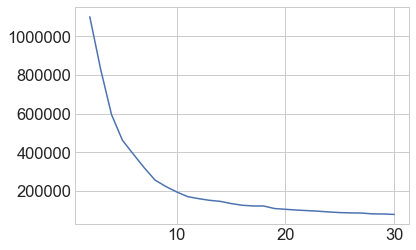

In [32]:
# todo: prettify
sns.lineplot(x = [k for k in range(2, 31)], y=inertia)

An obvious elbow-like structure can be observed at k=10, therefore, we proceed with 10 cluster for K Means clustering.

In [33]:
kmeans_cluster = KMeans(n_clusters=10, random_state=42).fit(data.iloc[:,7:])

## Kmeans Clustering Result

### 1. Bmi

In [34]:
temp = pd.crosstab(index = kmeans_cluster.labels_, columns = [data.bmi_cat])
temp['sum'] = temp.sum(axis = 1)
temp.div(temp["sum"], axis=0)

bmi_cat,Normal,Not provided,Obese,Overweight,Underweight,sum
row_0,,,,,,
0,0.543640,0.051272,0.096673,0.225832,0.082583,1.0
1,0.539696,0.071987,0.092966,0.215961,0.079391,1.0
2,0.538012,0.057830,0.099415,0.220923,0.083821,1.0
3,0.565985,0.064126,0.087361,0.200743,0.081784,1.0
4,0.517333,0.080000,0.085333,0.232000,0.085333,1.0
5,0.558824,0.041176,0.091176,0.232353,0.076471,1.0
6,0.554839,0.070968,0.090323,0.165591,0.118280,1.0
7,0.539683,0.052910,0.116402,0.211640,0.079365,1.0
8,0.594340,0.056604,0.084906,0.165094,0.099057,1.0


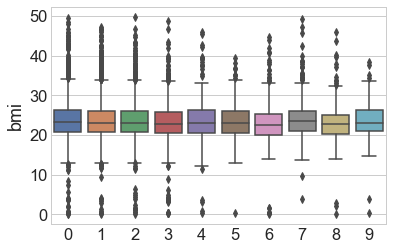

In [35]:
reduced_kmeans_cluster_labels_ = kmeans_cluster.labels_[data.bmi != 'Not provided']
reduced_bmi = data.bmi[(data.bmi != 'Not provided')].astype('float')
reduced_kmeans_cluster_labels_ = reduced_kmeans_cluster_labels_[reduced_bmi < 50]
reduced_bmi = reduced_bmi[reduced_bmi < 50]


sns.boxplot(reduced_kmeans_cluster_labels_, 
            y=reduced_bmi)

Discovery:

- Each cluster shares roughly the same proportion of bmi_cat.
- The distribution of bmi in each cluster does not differ from each other much, although bmi distributions for cluster 5 to 10 is much more concentrated.

### 2. Alcohol_Frequency

In [36]:
temp = pd.crosstab(kmeans_cluster.labels_, data.alcohol_frequency)
temp['sum'] = temp.sum(axis = 1)
temp.div(temp["sum"], axis=0)

alcohol_frequency,Daily,Never,Not provided,Occasionally (1-2 times/week),Rarely (a few times/month),Regularly (3-5 times/week),sum
row_0,,,,,,,
0,0.098239,0.232485,0.024658,0.219961,0.225832,0.198826,1.0
1,0.100782,0.213904,0.023036,0.227067,0.254216,0.180995,1.0
2,0.103964,0.224172,0.017544,0.222872,0.247563,0.183886,1.0
3,0.092937,0.228625,0.024164,0.210037,0.248141,0.196097,1.0
4,0.106667,0.245333,0.021333,0.157333,0.266667,0.202667,1.0
5,0.105882,0.273529,0.029412,0.197059,0.217647,0.176471,1.0
6,0.109677,0.249462,0.021505,0.172043,0.268817,0.178495,1.0
7,0.105820,0.201058,0.026455,0.235450,0.238095,0.193122,1.0
8,0.084906,0.240566,0.009434,0.193396,0.240566,0.231132,1.0


Discoveries:  

- People in cluster 9 are more likely to be occasional/rare drinkers
- Each cluster differs from each other in drinking habit by only a little amount.

# Clustering - Agglomerative Clustering

In [37]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

ax = plt.figure(figsize=(10, 8))
dendrogram = sch.dendrogram(sch.linkage(data.iloc[:,7:], method='complete'))
plt.title('Dendrogram')
plt.xlabel('Sample')
plt.show()

We have to choose a method out of gour for hierarchical clustering, their charateristics are summarized as follows:

- single linkage is fast, and can perform well on non-globular data, but it performs poorly in the presence of noise.
- average and complete linkage perform well on cleanly separated globular clusters, but have mixed results otherwise.
- Ward is the most effective method for noisy data.

To produce a more different result with Kmeans, we use a complete linkage where other than the default 'ward' method which compares the within clusters variance. We believe the data is rather noisy, therefore we choose to use the complete linkage.

From the dendrogram, choosing 3 to 8 clusters seems reasonable. For interpretability and for balancing sample size within each cluster, we'll use 3 here.

In [38]:
hierarchical_clusters = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(data.iloc[:,7:])

## Hierarchical Clustering Result

### 1. Bmi

In [39]:
temp = pd.crosstab(index = hierarchical_clusters.labels_, columns = [data.bmi_cat])
temp['sum'] = temp.sum(axis = 1)
temp.div(temp["sum"], axis=0)

In [40]:
reduced_hierarchical_clusters_labels_ = hierarchical_clusters.labels_[data.bmi != 'Not provided']
reduced_bmi = data.bmi[(data.bmi != 'Not provided')].astype('float')
reduced_hierarchical_clusters_labels_ = reduced_hierarchical_clusters_labels_[reduced_bmi < 50]
reduced_bmi = reduced_bmi[reduced_bmi < 50]


sns.boxplot(reduced_hierarchical_clusters_labels_, 
            y=reduced_bmi)

Discovery:

- Each cluster shares roughly the same proportion of bmi_cat.
- The distribution of bmi in each cluster does not differ from each other much, although bmi distributions for cluster 5 to 10 is much more concentrated.

### 2. Alcohol_Frequency

In [41]:
temp = pd.crosstab(hierarchical_clusters.labels_, data.alcohol_frequency)
temp['sum'] = temp.sum(axis = 1)
temp.div(temp["sum"], axis=0)

Discoveries:  

- No sigificant discoveries

# Supervised Learning - Modeling bmi_cat

## Data Preprocessing

### Concise categorical level

In [42]:
data.alcohol_frequency = data.alcohol_frequency.map({'Rarely (a few times/month)': 'Rarely',
                           'Never': 'Never',
                           'Occasionally (1-2 times/week)':'Occasionally',
                           'Regularly (3-5 times/week)': 'Regularly',
                           'Daily': 'Daily',
                           'Not provided': 'Not provided'})
data.race = data.race.map({'Caucasian': 'Cauc.',
                           'Asian or Pacific Islander': 'Asian',
                           'Other':'Other',
                           'Hispanic': 'Hisp.',
                           'African American ': 'Afri.',
                           'Not provided': 'Not provided'})

### Handling Missing Values

To model bmi_cat, we first discard any samples that are missing bmi_cat. 

In [43]:
bc_data = data.copy()
bc_data['alpha_diversity'] = alpha_diversity
bc_data['log_fb_ratio'] = np.log(fb_ratio)

print((bc_data.bmi_cat=='Not provided').sum())
bc_data.loc[(bc_data.bmi_cat=='Not provided'), 'bmi_cat'] = np.nan

bc_data = bc_data.dropna()

print('{} samples out of {} contain 1 or more missing values'.format((((bc_data == 'Not provided').sum(axis=1) > 0).sum()), bc_data.shape[0]))
(bc_data == 'Not provided').sum(axis=0)

578
571 samples out of 8876 contain 1 or more missing values


/Users/darrenwang/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


age_cat                          312
bmi                                0
bmi_cat                            0
weight_kg                          0
race                              60
sex                              203
alcohol_frequency                 82
Others                             0
k__Bacteria|p__Actinobacteria      0
k__Bacteria|p__Bacteroidetes       0
k__Bacteria|p__Firmicutes          0
k__Bacteria|p__Proteobacteria      0
k__Bacteria|p__Tenericutes         0
k__Bacteria|Others                 0
k_Archaea                          0
alpha_diversity                    0
log_fb_ratio                       0
dtype: int64

We considered three methods to deal with missing values:

1. Discard any sample that contains missing values
2. Leave them as 'Not provided' and treat it as a level in the variable
3. Imputation

Normally, method 2 is the choice if  
1. Large proportion of samples is missing a variable
2. We have reasons to believe that these missing values occur in a systematic way, for example, missing values in race could mean these samples are from a rare race
3. Missing values in a variable give information, in this case, that information refers to predictive power

Since these reasons do not apply to our case, we will not take method 2.  

Our data contains samples from multiple sources, popular imputation methods like MICE and mean/median value imputation are less likely to perform well here, so we'll discard most of the variables that contains missing values. We only partially imputed missing alcohol_frequencey for baby, child and teens because we can safely assume most of them never drink in these ages.

In [44]:
# impute missing values
bc_data.loc[(bc_data.age_cat.isin(['baby', 'child', 'teen'])) & (bc_data.alcohol_frequency == 'Not provided'), 'alcohol_frequency'] = 'Never'

In [45]:
bc_data[bc_data=='Not provided'] = np.nan
bc_data = bc_data.dropna()
print(bc_data.shape[0], 'samples left')

8311 samples left


## Discarding Babies, Children and Teens

Taken from Wikipedia:

BMI is used differently for children. It is calculated in the same way as for adults, but then compared to typical values for other children of the same age. Instead of comparison against fixed thresholds for underweight and overweight, the BMI is compared against the percentiles for children of the same sex and age.

A BMI that is less than the 5th percentile is considered underweight and above the 95th percentile is considered obese. Children with a BMI between the 85th and 95th percentile are considered to be overweight.  

Samples in these age groups do not share the same BMI category system as the others. Therefore, babies, children and teens should be excluded from the dataset for modeling.

In [46]:
bc_data.drop(bc_data[bc_data.age_cat.isin(['baby', 'child', 'teen'])].index, inplace=True)

### Merge Overwight and Obese - No Improvement

From Wikipedia, we define a person to be underweight if bmi is lower than 16, normal if between 16 to 25, overweight if higher than 25 but below 30, and obese if above 30. Take into account that bmi range is smaller for overweight than normal, and the smaller size of overweight sample in our dataset, we merge overweight samples and obese samples and form the new 'overweight' class for improvement.

In [47]:
# bc_data.loc[bc_data.bmi_cat == 'Obese', 'bmi_cat'] = 'Overweight'
# bc_data = bc_data.loc[bc_data.bmi_cat.isin(['Overweight', 'Normal']),]

## Outlier Detection

According to Google, the heaviest man on record weighted 594.8 kg and had a bmi of 180. The lower right dot with weight over 600 kg must be an outlier. We also noticed there's a group with rather low weight and bmi above 100, intuitively we thought these must be severely overweight teens or children, however they all aged over 30. Hence these are outlier and should be exclude from modeling. It's hard to say whether these samples with bmi greater than 100 are real but to be more conservative we decided to leave them in the data.

In [48]:
ol1 = bc_data.loc[(bc_data.weight_kg.astype('float') < 200) & (bc_data.bmi.astype('float') > 100), :]
ol2 = bc_data.loc[(bc_data.weight_kg.astype('float') > 600), :]
ol1

,age_cat,bmi,bmi_cat,weight_kg,race,sex,alcohol_frequency,Others,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Tenericutes,k__Bacteria|Others,k_Archaea,alpha_diversity,log_fb_ratio
3292,30s,136.53,Obese,65.0,Cauc.,male,Regularly,3.429468,6.404398,6.684166,6.001182,5.362693,-15.390374,2.898840,-15.390374,86,-0.609383
3293,60s,143.61,Obese,57.0,Cauc.,female,Regularly,-0.781664,-1.843575,3.503146,3.639201,-0.038393,0.516769,-1.150428,-3.845055,255,0.146803
3294,30s,131.84,Obese,54.0,Cauc.,female,Occasionally,5.068118,4.098718,10.468930,10.040562,6.445755,-12.040694,-12.040694,-12.040694,172,-0.422268
3592,50s,130.07,Obese,50.0,Cauc.,female,Daily,0.709420,1.186344,5.288845,5.831481,3.005036,2.424218,-1.775487,-16.669856,234,0.546080
4284,20s,166.11,Obese,68.0,Asian,male,Rarely,3.803808,-14.833002,7.120860,7.613740,5.597320,3.335907,2.194370,-14.833002,356,0.504717
5953,70+,150.88,Obese,58.0,Cauc.,female,Regularly,1.439161,1.794364,4.099009,5.178580,1.947041,2.154127,0.830571,-17.442855,220,1.079416


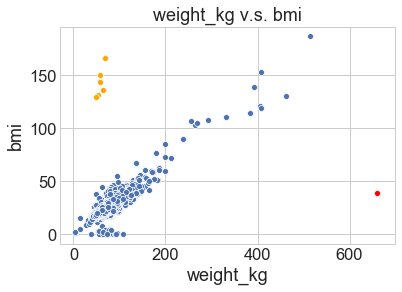

In [49]:
ax = sns.scatterplot(x=bc_data.weight_kg.astype('float'), y=bc_data.bmi.astype('float'))
ax1 = sns.scatterplot(x=ol1.weight_kg.astype('float'), y=ol1.bmi.astype('float'), color='orange')
ax2 = sns.scatterplot(x=ol2.weight_kg.astype('float'), y=ol2.bmi.astype('float'), color='red')
t = plt.title('weight_kg v.s. bmi')

In [50]:
bc_data.drop(bc_data.loc[(bc_data.weight_kg.astype('float') < 200) & (bc_data.bmi.astype('float') > 100), :].index, inplace=True)

In [51]:
bc_data.drop(bc_data.loc[(bc_data.weight_kg.astype('float') > 600), :].index, inplace=True)

In [53]:
# height_m = sqrt(weight_kg / bmi)
bc_data['height_m'] = np.sqrt(bc_data.weight_kg.astype('float') / bc_data.bmi.astype('float'))
ol1 = bc_data[bc_data.height_m > 2.5]

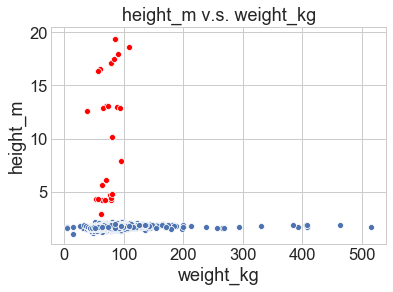

In [54]:
ax = sns.scatterplot(x=bc_data.weight_kg.astype('float'), y=bc_data.height_m)
ax1 = sns.scatterplot(x=ol1.weight_kg.astype('float'), y=ol1.height_m, color='red')
t = plt.title('height_m v.s. weight_kg')

In [55]:
# Every sample having height_m over 2.5 can be removed as outliers
bc_data.drop(bc_data[bc_data.height_m > 2.5].index, inplace=True)

# Also, having weight < 20kg as an adult should be deleted
bc_data.drop(bc_data[bc_data.weight_kg.astype('float')<20].index, inplace=True)

## EDA & Feature Engineering

### Discarding bmi and weight_kg

We discard bmi and weight_kg since we are most likely to find perfect correlation between bmi_cat and these two variables.

In [56]:
bc_data = bc_data.drop(['bmi', 'weight_kg', 'height_m'], axis=1)

### Class imbalance of bmi_cat

We face serious class imbalance problem, resampling method should be preformed before modeling bmi_cat

Normal         4686
Overweight     1898
Obese           811
Underweight     316
Name: bmi_cat, dtype: int64


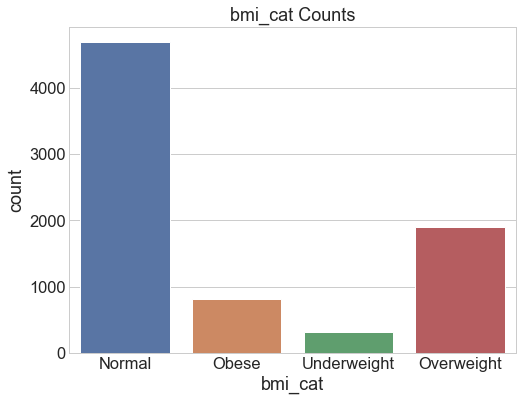

In [57]:
print(bc_data.bmi_cat.value_counts())
plt.figure(figsize=(8,6))
ax = sns.countplot(bc_data.bmi_cat)
t = plt.title('bmi_cat Counts')

### Adding alpha diversity and log F/B ratio

Two additional features mentioned in [Minhoo Kim & Berenice](https://www.sciencedirect.com/science/article/pii/S2468501120300146) are taken into consideration, alpha diversity and F/B ratio. 

We take natural log of the F/B ratio since originally it was highly right-skewed.

### Univariale Analysis

In this section, we examine how each variables interact with bmi_cat.

#### Categorical Variables - age_cat, race, sex, alcohol_frequency

In [58]:
def univariate_cat(data, target, var_list, nrow, ncol, w=12, h=10, wspace=0.3, hspace=0.3):
    from math import ceil
    fig = plt.figure(figsize=(w, h))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    
#     fig, axes = plt.subplots(nrows=nrow, ncols=ncol)
    for i, var in enumerate(var_list):
        table = pd.crosstab(data[var], data[target])
        table = table.div(table.sum(axis=1), axis=0)
        ax = fig.add_subplot(nrow, ncol, i+1)
        table.plot(kind='bar', stacked=True, ax=ax)
        plt.xlabel(var, weight='bold')
        plt.ylabel('Fraction of Total')
        if i % nrow != 0:
            plt.legend(loc='lower right', bbox_to_anchor=(1.6, 0))
        else:
            ax.get_legend().remove()

# univariate_cat(bc_data, 'bmi_cat', ['age_cat', 'race', 'sex', 'alcohol_frequency'], 2, 2)

Discoveries:

- Caucassian and Hispanic people are a little more likely to be overweight/obese.
- Asians are more likely to be underweight
- Males are more likely to be overweight/obese than females
- Females are more likely to be underweight than males
- People who never drink are more likely to be underweight
    

#### Treating age_cat & alcohol_freqeuncy as ordinal variables

Due to the ordinal nature, we can consider treating these two variables as ordinal features other than categorical features. Two advantage of doing so:  

1. take advantage of linear relationship with the target variable. (if there's any)
2. other than doing one-hot encoding, this prevent us from growing data dimension 

In [59]:
age_map = {'baby': 0, 'child': 1, 'teen': 2, '20s': 3, '30s': 4, '40s': 5, '50s': 6, '60s': 7, '70+': 8}
alcohol_map = {'Never': 0, 'Rarely':1, 'Occasionally': 2, 'Regularly': 3, 'Daily': 4}

bc_data['age_ordinal'] = bc_data.age_cat.map(age_map)
bc_data['alc_ordinal'] = bc_data.alcohol_frequency.map(alcohol_map)

#### Continuous Variables

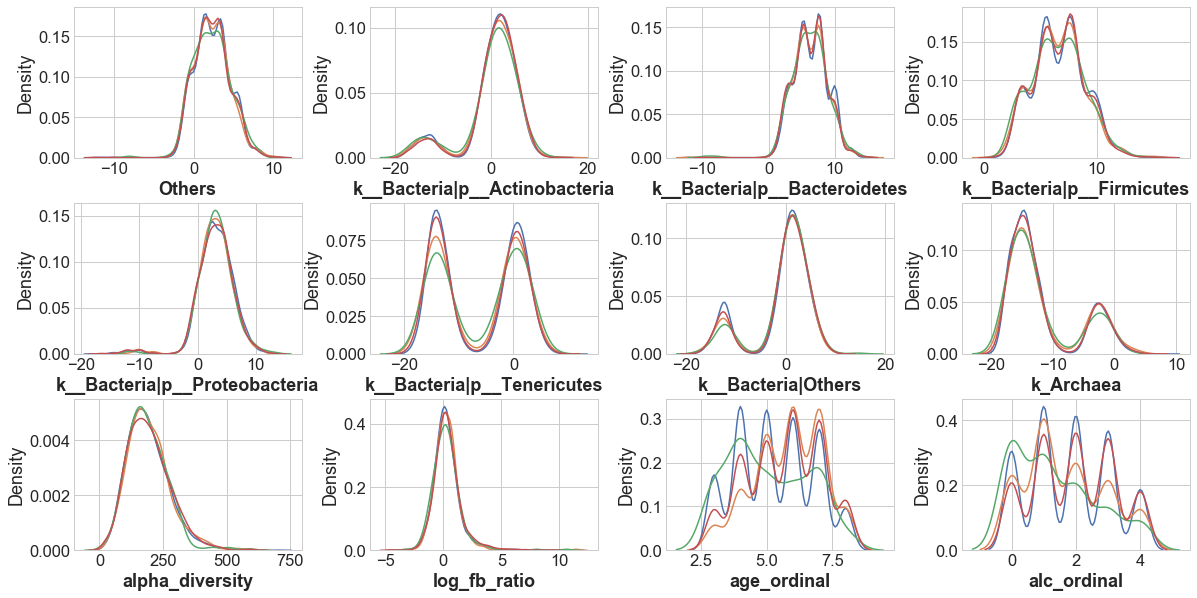

In [66]:
def univariate_con(data, target, var_list, nrow, ncol, w=20, h=10, wspace=0.3, hspace=0.3):
    from math import ceil
    fig = plt.figure(figsize=(w, h))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    
    for i, var in enumerate(var_list):
        ax = fig.add_subplot(nrow, ncol, i+1)
        for cat in data[target].unique():
            sns.distplot(data.loc[data[target]==cat, var], hist=False, kde=True)
        plt.xlabel(var, weight='bold')
        plt.ylabel('Density')
            
univariate_con(bc_data, 'bmi_cat', bc_data.columns[5:], 3, 4)

Discoveries:

- These microbiome variables do not have much predictive power, the distribution of these microbiome all look identical across different bmi_cat.
- However this does not take into account bi-variate or tri-variate effect

# Modeling 

### Categorical Variable Encoding

In [182]:
bc_data = pd.get_dummies(bc_data, columns=['sex', 'race'])
bc_data = bc_data.drop(['age_cat', 'alcohol_frequency'], axis=1)

### Train-test split

In [183]:
from sklearn.model_selection import train_test_split

# train test split 
X, y = bc_data.drop('bmi_cat', axis=1), bc_data.bmi_cat

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1)

### Random Forest with Class Weight

In [184]:
from sklearn.ensemble import RandomForestClassifier

baseline_model = RandomForestClassifier(random_state=42, n_estimators=50, class_weight='balanced', min_samples_split=10, oob_score=True)

baseline_model.fit(X_train, y_train)

# feature importance
feature_importances = pd.DataFrame({'Importance Score': baseline_model.feature_importances_}, index=X_train.columns).sort_values(by='Importance Score', ascending=False)

# top 10 features by importance
feature_importances[:10]

,Importance Score
k__Bacteria|Others,0.088945
k__Bacteria|p__Actinobacteria,0.088037
k__Bacteria|p__Proteobacteria,0.087043
log_fb_ratio,0.086723
alpha_diversity,0.086059
Others,0.085883
k__Bacteria|p__Firmicutes,0.084368
k__Bacteria|p__Tenericutes,0.080984
k_Archaea,0.080042
k__Bacteria|p__Bacteroidetes,0.079809


In [185]:
bc_data.isna().sum(axis=0)

bmi_cat                          0
Others                           0
k__Bacteria|p__Actinobacteria    0
k__Bacteria|p__Bacteroidetes     0
k__Bacteria|p__Firmicutes        0
k__Bacteria|p__Proteobacteria    0
k__Bacteria|p__Tenericutes       0
k__Bacteria|Others               0
k_Archaea                        0
alpha_diversity                  0
log_fb_ratio                     0
age_ordinal                      0
alc_ordinal                      0
sex_female                       0
sex_male                         0
sex_other                        0
race_Asian                       0
race_Cauc.                       0
race_Hisp.                       0
race_Other                       0
dtype: int64

In [186]:
print(baseline_model.score(X_train, y_train))
print(baseline_model.score(X_test, y_test))

0.9815535379737714
0.560880829015544


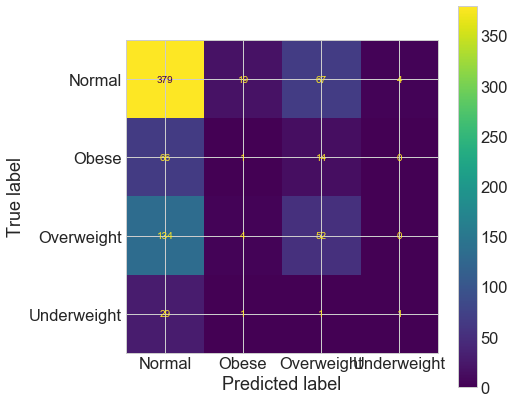

In [187]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

fig, ax = plt.subplots(figsize=(7, 7))
ax = plot_confusion_matrix(baseline_model, X_test, y_test, ax=ax) 

### Parameters tuning with CV

We saw severe overfitting in the baseline model, even when each class was equally weighted, the model predict poorly for each class. We further use cross-validation to tune the model.

In [200]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
# param_grid = {
#     'max_depth': [20, 30, 40],
#     'max_features': [5, 6, 7],
#     'min_samples_leaf': [5, 10 ,15, 20, 30],
#     'min_samples_split': [10, 15, 20],
#     'n_estimators': [150, 300, 500]
# }

param_grid = {
    'max_depth': [30],
    'max_features': [6],
    'min_samples_leaf': [10],
    'min_samples_split': [10],
    'n_estimators': [300]
}

# Create a based model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'f1_weighted',
                          cv = 3, n_jobs = -1, verbose = 2)

In [201]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished


{'max_depth': 30,
 'max_features': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 300}

In [207]:
from sklearn.metrics import f1_score

grid_search.best_score_
pred = grid_search.predict(X_test)
f1_score(pred, y_test, average = 'weighted')

0.4839582934434544

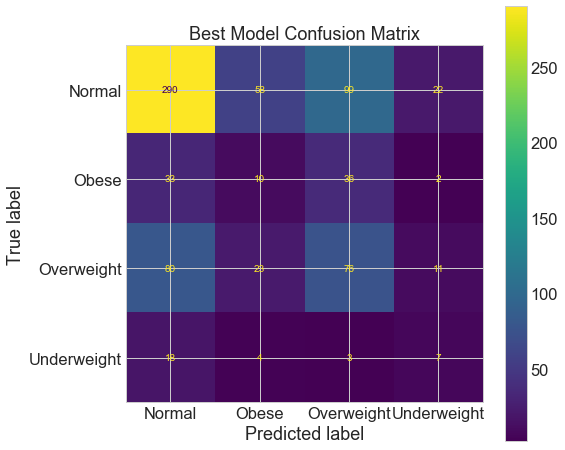

In [208]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_confusion_matrix(grid_search, X_test, y_test, ax=ax) 
t = plt.title('Best Model Confusion Matrix')

In [209]:
del bc_data, grid_search, baseline_model, rf, param_grid, X, y, X_train, X_test, y_train, y_test

### Dealing with Class imbalance - Oversampling 

In [118]:
bc_data.bmi_cat.value_counts()

Normal         4686
Overweight     2709
Underweight     316
Name: bmi_cat, dtype: int64

In [84]:
y.value_counts()

Normal         4686
Overweight     1898
Obese           811
Underweight     316
Name: bmi_cat, dtype: int64

In [128]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# train test split 
X, y = bc_data.drop('bmi_cat', axis=1), bc_data.bmi_cat

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2)
oversample = SMOTE(sampling_strategy={'Underweight':500}, random_state=42)
# oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy={'Normal': 2500, 'Overweight': 1500}, random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)



In [129]:
y_train.value_counts()

Normal         2500
Overweight     1500
Underweight     500
Name: bmi_cat, dtype: int64

In [130]:
baseline_model.fit(X_train, y_train)

# feature importance
feature_importances = pd.DataFrame({'Importance Score': baseline_model.feature_importances_}, index=X_train.columns).sort_values(by='Importance Score', ascending=False)

# top 10 features by importance
feature_importances[:10]

,Importance Score
alpha_diversity,0.088473
k__Bacteria|Others,0.085144
k__Bacteria|p__Proteobacteria,0.082424
sex_male,0.080247
log_fb_ratio,0.075986
k_Archaea,0.075568
k__Bacteria|p__Actinobacteria,0.074874
k__Bacteria|p__Tenericutes,0.073963
Others,0.073752
k__Bacteria|p__Bacteroidetes,0.071789


In [131]:
print(baseline_model.score(X_train, y_train))
print(baseline_model.score(X_test, y_test))

0.9835555555555555
0.5813350615683733


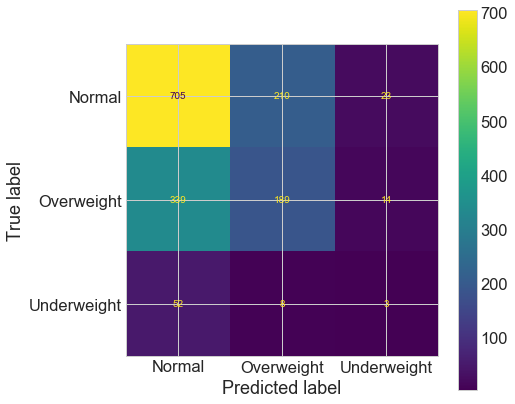

In [132]:
fig, ax = plt.subplots(figsize=(7, 7))
ax = plot_confusion_matrix(baseline_model, X_test, y_test, ax=ax) 

In [133]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [20, 30, 40],
    'max_features': [5, 6, 7],
    'min_samples_leaf': [10 ,20, 30],
    'min_samples_split': [10, 15, 20],
    'n_estimators': [150, 300, 500]
}

# param_grid = {
#     'max_depth': [30],
#     'max_features': [6],
#     'min_samples_leaf': [10, 11, 12, 13, 14, 15],
#     'min_samples_split': [15],
#     'n_estimators': [300]
# }

# Create a based model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'f1_weighted',
                          cv = 3, n_jobs = -1, verbose = 2)

In [134]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.4s


KeyboardInterrupt: 

In [126]:
print(grid_search.score(X_train, y_train))
print(grid_search.score(X_test, y_test))

0.8002690513329764
0.4388801460168602


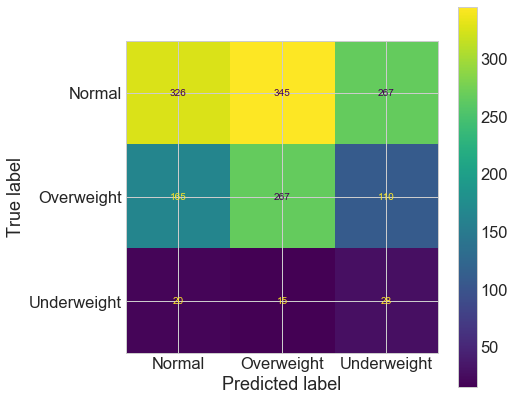

In [127]:
fig, ax = plt.subplots(figsize=(7, 7))
ax = plot_confusion_matrix(grid_search, X_test, y_test, ax=ax) 

# Supervised Learning - Modeling alcohol_frequency

In [292]:
af_data = data.copy()
af_data['alpha_diversity'] = alpha_diversity
af_data['log_fb_ratio'] = np.log(fb_ratio)

af_data.loc[(af_data.alcohol_frequency=='Not provided'), 'alcohol_frequency'] = np.nan

af_data = af_data.dropna()

print('{} samples out of {} contain 1 or more missing values'.format((((af_data == 'Not provided').sum(axis=1) > 0).sum()), af_data.shape[0]))
(af_data == 'Not provided').sum(axis=0)

924 samples out of 9229 contain 1 or more missing values


/Users/darrenwang/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


age_cat                          384
bmi                              172
bmi_cat                          435
weight_kg                        120
race                              49
sex                              256
alcohol_frequency                  0
Others                             0
k__Bacteria|p__Actinobacteria      0
k__Bacteria|p__Bacteroidetes       0
k__Bacteria|p__Firmicutes          0
k__Bacteria|p__Proteobacteria      0
k__Bacteria|p__Tenericutes         0
k__Bacteria|Others                 0
k_Archaea                          0
alpha_diversity                    0
log_fb_ratio                       0
dtype: int64

### Drop babies, children, and teens

Again, it's almost certain that people in this age never drink, so including these samples in our model does not make any sense.

In [293]:
af_data.drop(af_data[af_data.age_cat.isin(['baby', 'child', 'teen'])].index, inplace=True)

### For the same reason as bmi_cat, we drop any sample that contains missing values

In [294]:
af_data[af_data=='Not provided'] = np.nan
af_data = af_data.dropna()
print(af_data.shape[0], 'samples left')

7750 samples left


Drop the same set of outliers from bmi_cat

In [295]:
af_data.drop(af_data.loc[(af_data.weight_kg.astype('float') < 200) & (af_data.bmi.astype('float') > 100), :].index, inplace=True)
af_data.drop(af_data.loc[(af_data.weight_kg.astype('float') > 600), :].index, inplace=True)

In [296]:
### Similarly, add height_m and delete outliers over 2.5 m tall and under 20kg weight

# height_m = sqrt(weight_kg / bmi)
af_data['height_m'] = np.sqrt(af_data.weight_kg.astype('float') / af_data.bmi.astype('float'))
af_data.drop(af_data[af_data.height_m > 2.5].index, inplace=True)
af_data.drop(af_data[af_data.weight_kg.astype('float') < 20].index, inplace=True)

In [297]:
af_data[af_data.weight_kg.astype('float')<30]

,age_cat,bmi,bmi_cat,weight_kg,race,sex,alcohol_frequency,Others,k__Bacteria|p__Actinobacteria,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Tenericutes,k__Bacteria|Others,k_Archaea,alpha_diversity,log_fb_ratio,height_m
1619,60s,9.4,Underweight,28.0,Cauc.,female,Rarely,0.144427,-0.430937,6.429261,5.319870,2.053969,1.530721,1.243039,-16.290351,167,-1.103766,1.725898
5836,40s,9.03,Underweight,27.0,Cauc.,female,Rarely,5.564544,7.081291,9.591650,9.542232,6.313482,-12.697733,-12.697733,-12.697733,132,-0.046941,1.729171


## EDA & Feature Engineering

### height_m 

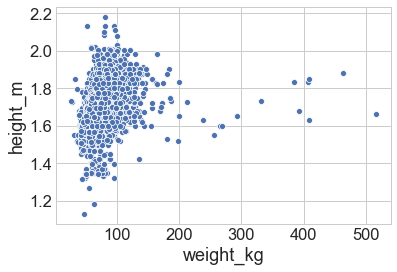

In [298]:
sns.scatterplot(x=af_data.weight_kg.astype('float'), y=af_data.height_m)

### Class imbalance of alcohol_frequency

Class imbalance is moderate in alcohol_frequency comparing to bmi_cat, we can use standard modeling and first and apply resampling or sample weight techniques if minor classes were predicted poorly.

Rarely          2028
Occasionally    1838
Regularly       1631
Never           1359
Daily            855
Name: alcohol_frequency, dtype: int64


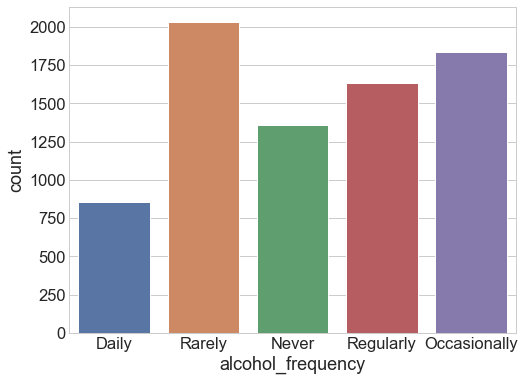

In [299]:
print(af_data.alcohol_frequency.value_counts())
plt.figure(figsize=(8,6))
ax = sns.countplot(af_data.alcohol_frequency)

### Adding alpha diversity and log F/B ratio


Two additional features mentioned in [Minhoo Kim & Berenice](https://www.sciencedirect.com/science/article/pii/S2468501120300146) are taken into consideration, alpha diversity and F/B ratio. 

We take natural log of the F/B ratio since originally it was highly right-skewed.

### Univariale Analysis


#### Categorical Variables - age_cat, race, sex, bmi_cat

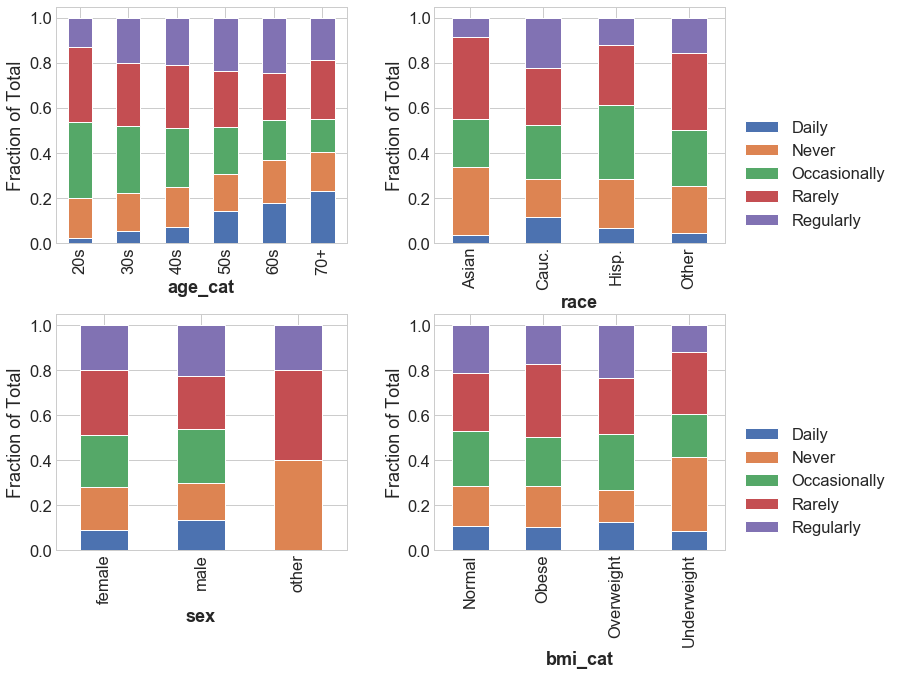

In [300]:
univariate_cat(af_data, 'alcohol_frequency', ['age_cat', 'race', 'sex', 'bmi_cat'], 2, 2)

Discoveries:

- It's surprising to see that proportion of daily drinker rise with age almost exponentially
- Asians have to most rarely drinkers and people who never drink
- Caucassian people drink the most
- Underweight people have the most non-drinkers (which may due to sampling error because of small sample size)
- Surprisingly, the largest group in obese samples rarely drinks.
    

In [301]:
age_map = {'baby': 0, 'child': 1, 'teen': 2, '20s': 3, '30s': 4, '40s': 5, '50s': 6, '60s': 7, '70+': 8}

af_data['age_ordinal'] = af_data.age_cat.map(age_map)

#### Continuous Variables

In [302]:
con = list(af_data.columns[7:])
con.append('bmi')
con.append('weight_kg')

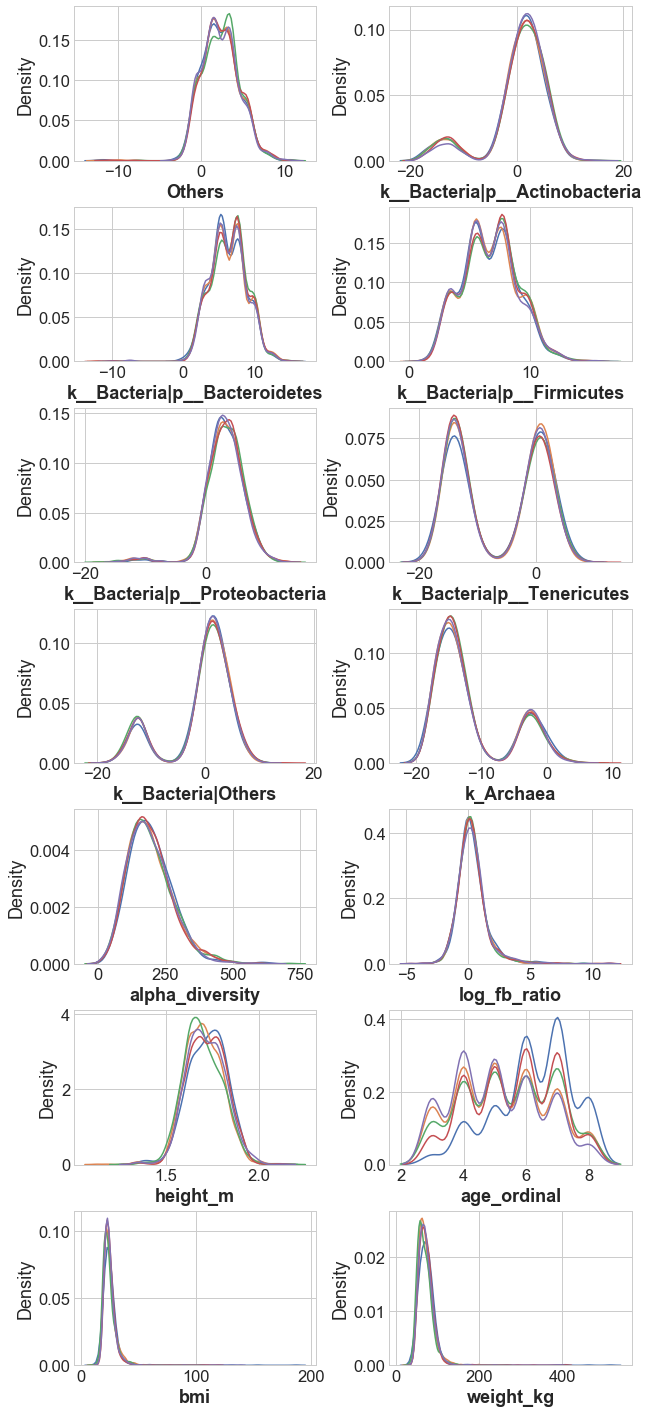

In [303]:
af_data.weight_kg = af_data.weight_kg.astype('float')
af_data.bmi = af_data.bmi.astype('float')
univariate_con(af_data, 'alcohol_frequency', con, 7, 2, w=10, h=25, wspace=0.3, hspace=0.3)

### Interaction between BMI, weight_kg, and height_m

Seriosu colinearity between bmi, weight, and height is expected, their corrrelation is visualized with heatmap below, to model alcohol_frequency, we use height and weight but not bmi since height has less correlation with the others and weight spans a wider range and seems to differentiate alcohol_frequency better in the univariate plot, and we already have bmi_cat in the dataset. 

We'll also take natural log of weight_kg since it's radically skewed.

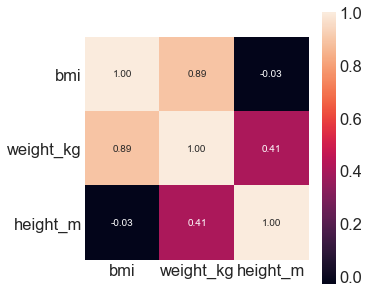

In [304]:
plt.figure(figsize=(5, 5))
sns.heatmap(af_data[['bmi', 'weight_kg', 'height_m']].corr(), annot=True, fmt='.2f', square=True)

In [305]:
af_data.drop('bmi', axis=1, inplace=True)
af_data['log_weight_kg'] = np.log(af_data.weight_kg)
af_data.drop('weight_kg', axis=1, inplace=True)

# Modeling

## Categorical Variable Encoding

In [306]:
af_data = pd.get_dummies(af_data, columns=['sex', 'race', 'bmi_cat'])
af_data = af_data.drop(['age_cat'], axis=1)

### Train-test split

In [307]:
from sklearn.model_selection import train_test_split

# train test split 
X, y = af_data.drop('alcohol_frequency', axis=1), af_data.alcohol_frequency

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1)

### Fitting Ada-Boost

In [317]:
# tuning for the best number of estimators with cv_score
# using default desicion tree as base learner
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": [20],
             'base_estimator__max_depth': [1],
             'base_estimator__min_samples_split': [30, 30, 50],
             'base_estimator__min_samples_leaf': [30]}

base = DecisionTreeClassifier(random_state = 42, class_weight='balanced')

abc = AdaBoostClassifier(base_estimator=base)

# run grid search
grid_search_abc = GridSearchCV(abc, param_grid=param_grid, scoring = 'f1_weighted', cv = 3, n_jobs = -1, verbose = 2)

In [318]:
grid_search_abc.fit(X_train, y_train)
grid_search_abc.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.9s finished


{'base_estimator__max_depth': 1,
 'base_estimator__min_samples_leaf': 30,
 'base_estimator__min_samples_split': 30,
 'n_estimators': 20}

In [327]:
from sklearn.metrics import f1_score

grid_search_abc.best_score_
pred = grid_search_abc.predict(X_test)
f1_score(pred, y_test, average = 'weighted')

0.2738894613307694

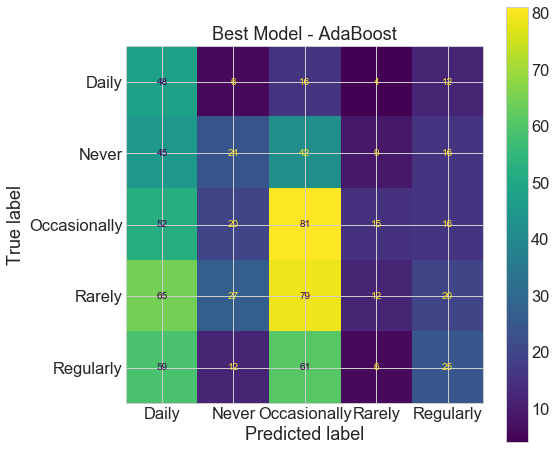

In [320]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_confusion_matrix(grid_search_abc, X_test, y_test, ax=ax) 
t = plt.title('Best Model - AdaBoost')

In [323]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {"n_neighbors": [i for i in range(1, 20)]}
knn = KNeighborsClassifier()

# run grid search
grid_search_knn = GridSearchCV(knn, param_grid=param_grid, scoring = 'f1_weighted', cv = 3, n_jobs = -1, verbose = 2)

In [324]:
grid_search_knn.fit(X_train, y_train)
grid_search_knn.best_params_

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    4.5s finished


{'n_neighbors': 10}

In [328]:
from sklearn.metrics import f1_score

grid_search_knn.best_score_
pred = grid_search_knn.predict(X_test)
f1_score(pred, y_test, average = 'weighted')

0.2304634451758691

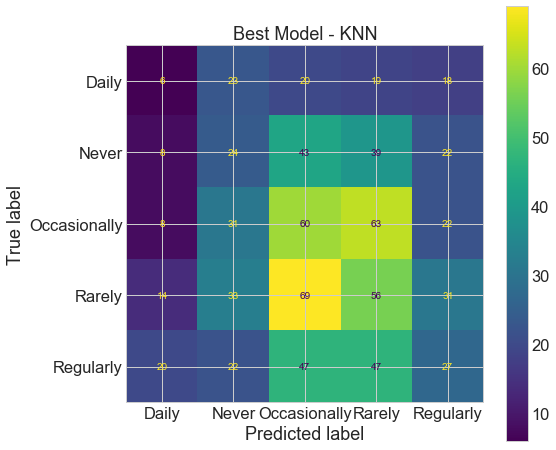

In [326]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_confusion_matrix(grid_search_knn, X_test, y_test, ax=ax) 
t = plt.title('Best Model - KNN')

### Downgrading the Problem - Binning alcohol_frequency

Bin Daily and Regularly into new level 'Frequent', Rarely and Occasionally into 'Occasionally'.

In [283]:
bin_map = {'Never': 'Not Daily',
          'Occasionally': 'Not Daily',
          'Rarely': 'Not Daily',
          'Daily': 'Daily',
          'Regularly': 'Not Daily'}

af_data['binned_freq'] = af_data.alcohol_frequency.map(bin_map)

In [284]:
af_data.binned_freq.value_counts()

Not Daily    6856
Daily         855
Name: binned_freq, dtype: int64

In [286]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# train test split 
X, y = af_data.drop(['alcohol_frequency', 'binned_freq'], axis=1), af_data.binned_freq

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1)

oversample = SMOTE(sampling_strategy={'Daily':1200}, random_state=42)
# oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy={'Not Daily': 2000}, random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [287]:
y_train.value_counts()

Not Daily    2000
Daily        1200
Name: binned_freq, dtype: int64

In [288]:
from sklearn.model_selection import train_test_split

# train test split 
X, y = af_data.drop(['alcohol_frequency', 'binned_freq'], axis=1), af_data.binned_freq

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.1)

In [289]:
grid_search_abc.fit(X_train, y_train)
grid_search_abc.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  8.5min finished


{'base_estimator__max_depth': 3,
 'base_estimator__min_samples_leaf': 5,
 'base_estimator__min_samples_split': 30,
 'n_estimators': 250}

In [290]:
grid_search_abc.best_score_

0.8266697435047248

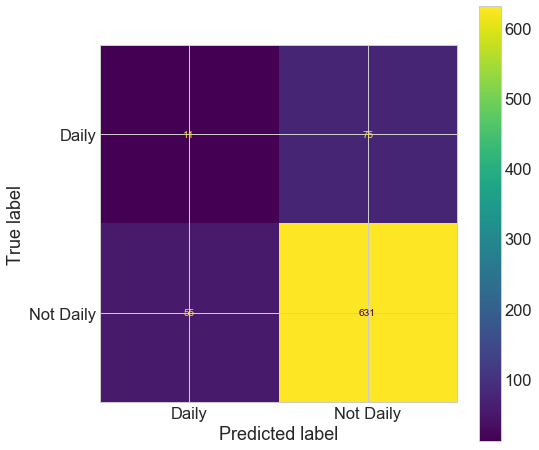

In [291]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = plot_confusion_matrix(grid_search_abc, X_test, y_test, ax=ax) 

# Try without greeedily merging columns - No Improvement

In [ ]:
def mergeBacteria(df, level = None):
    '''
    General function to merge data upto the level provided by the user.
    Pass level =1 for Phylum, =2 for Class, =3 for Order and so on.
    '''
    testdf = df.iloc[:,:7]
    upper_levels = np.unique([col.split('|')[level] for col in df.columns[7:]])
    for name in upper_levels:
        colarr = [col for col in df.columns[7:] if name in col]
        testdf[colarr[0].rsplit('|', 6-level)[0]] = df[colarr].sum(axis = 1)
    return testdf

In [ ]:
df_by_phylums = mergeBacteria(data, 2)

In [ ]:
from scipy.stats.mstats import gmean
# replace zeros with a small numbers
df_by_phylums = df_by_phylums.replace(0, 1e-10)

# apply clr transformation
df_by_phylums.iloc[:,7:] = np.log(df_by_phylums.iloc[:,7:].div(gmean(df_by_phylums.iloc[:,7:],axis=1), axis=0))

In [ ]:
df_by_phylums[df_by_phylums=='Not provided'] = np.nan
df_by_phylums = df_by_phylums.dropna()
print(df_by_phylums.shape[0], 'samples left')

In [389]:
(data_copy.iloc[:,7:] != 0).sum(axis=1).max()

708